In [ ]:
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from utils_baseline import *
from utils_preprocess import *
from utils_explain import *
from utils_perturbation import *
from utils_visualization import*

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
# Specify the file path
file_path_train = "./sample_data/train.csv"
file_path_test =  "./sample_data/test.csv"


df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

# Display the first few rows of the DataFrame to verify the data has been read correctly
print(df_train.head())

  policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster  \
0   ID00001       0.515874        0.05             0.644231           C1   
1   ID00002       0.672619        0.02             0.375000           C2   
2   ID00003       0.841110        0.02             0.384615           C3   
3   ID00004       0.900277        0.11             0.432692           C4   
4   ID00005       0.596403        0.11             0.634615           C5   

   population_density  make segment model fuel_type  ... is_brake_assist  \
0                4990     1       A    M1       CNG  ...              No   
1               27003     1       A    M1       CNG  ...              No   
2                4076     1       A    M1       CNG  ...              No   
3               21622     1      C1    M2    Petrol  ...             Yes   
4               34738     2       A    M3    Petrol  ...              No   

  is_power_door_locks is_central_locking  is_power_steering  \
0                  No  

In [3]:
# Concatenate the two data frames along axis 0 (rows)
df = pd.concat([df_train, df_test])
df = df.drop(['policy_id'], axis=1)

In [4]:
df.head()

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0.0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0.0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0.0
3,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0.0
4,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0.0


In [5]:
df = df.dropna()

In [6]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df.loc[:, col] = label_encoder.fit_transform(df[col])

df.head()

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,0,4990,1,0,0,0,5,...,0,0,0,1,0,0,0,1,0,0.0
1,0.672619,0.02,0.375000,11,27003,1,0,0,0,5,...,0,0,0,1,0,0,0,1,0,0.0
2,0.841110,0.02,0.384615,15,4076,1,0,0,0,5,...,0,0,0,1,0,0,0,1,0,0.0
3,0.900277,0.11,0.432692,16,21622,1,3,3,2,0,...,1,1,1,1,1,1,1,1,2,0.0
4,0.596403,0.11,0.634615,17,34738,2,0,4,2,8,...,0,1,1,1,0,1,1,1,2,0.0


In [7]:
y = df['is_claim']
X = df.drop(['is_claim'], axis=1)
X = X.astype({col: 'category' for col in df.select_dtypes(include=['object']).columns})


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y )
X_Cal, X_test,  y_cal, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42 )  

In [8]:
y_test.value_counts()

is_claim
0.0    13686
1.0      962
Name: count, dtype: int64

In [9]:
len(X_train.columns)

42

In [11]:
# Initialize an XGBoost classifier
model_base = xgb.XGBClassifier(objective='binary:logistic', random_state=42, enable_categorical=True)

# Train the classifier on the training data
model_base.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model_base.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9334380120152922
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97     13686
         1.0       0.24      0.01      0.01       962

    accuracy                           0.93     14648
   macro avg       0.59      0.50      0.49     14648
weighted avg       0.89      0.93      0.90     14648


In [12]:
class_labels = ['no', 'yes']
feature_names = list(X_train.columns)

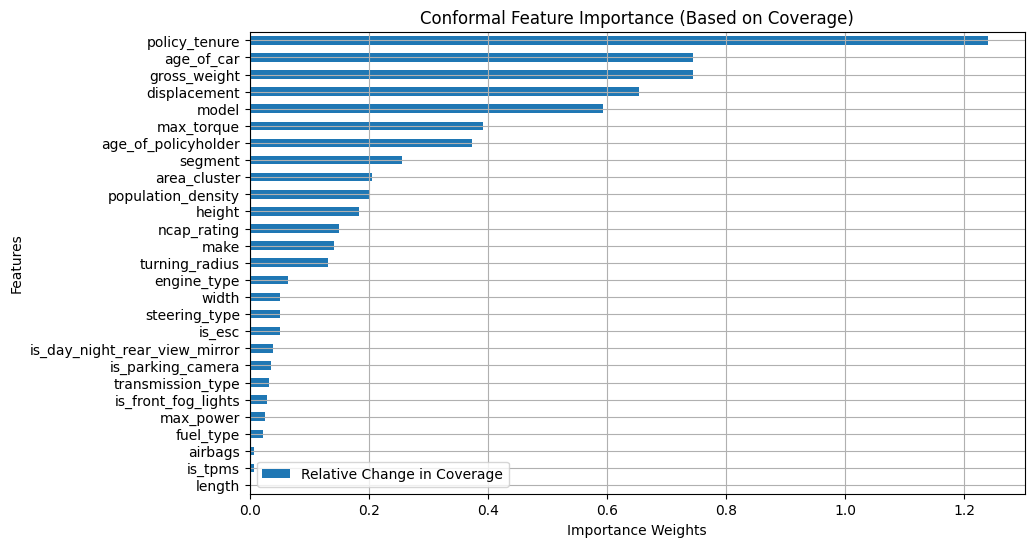

,Relative Change in Coverage
Perturbed_Column,
policy_tenure,1.239580
age_of_car,0.743748
gross_weight,0.743748
displacement,0.653924
model,0.592843
max_torque,0.391636
age_of_policyholder,0.373671
segment,0.255102
area_cluster,0.204800


In [15]:
type_of_metric = 'coverage'
noise_type = 'gaussian'
alpha = 0.05
plot_conformal_explainer(model_base, X_Cal, y_cal, X_test, y_test, alpha, class_labels, type_of_metric, noise_type)

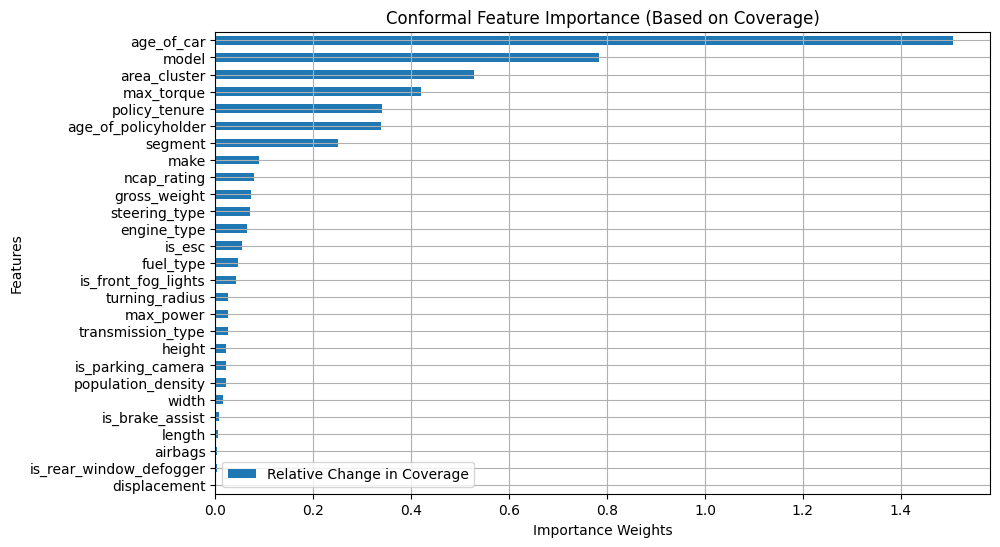

,Relative Change in Coverage
Perturbed_Column,
age_of_car,1.507258
model,0.783271
area_cluster,0.528169
max_torque,0.420379
policy_tenure,0.339537
age_of_policyholder,0.337741
segment,0.251509
make,0.089825
ncap_rating,0.079046


In [16]:
type_of_metric = 'coverage'
noise_type = 'uniform'
alpha = 0.05
plot_conformal_explainer(model_base, X_Cal, y_cal, X_test, y_test, alpha, class_labels, type_of_metric, noise_type)

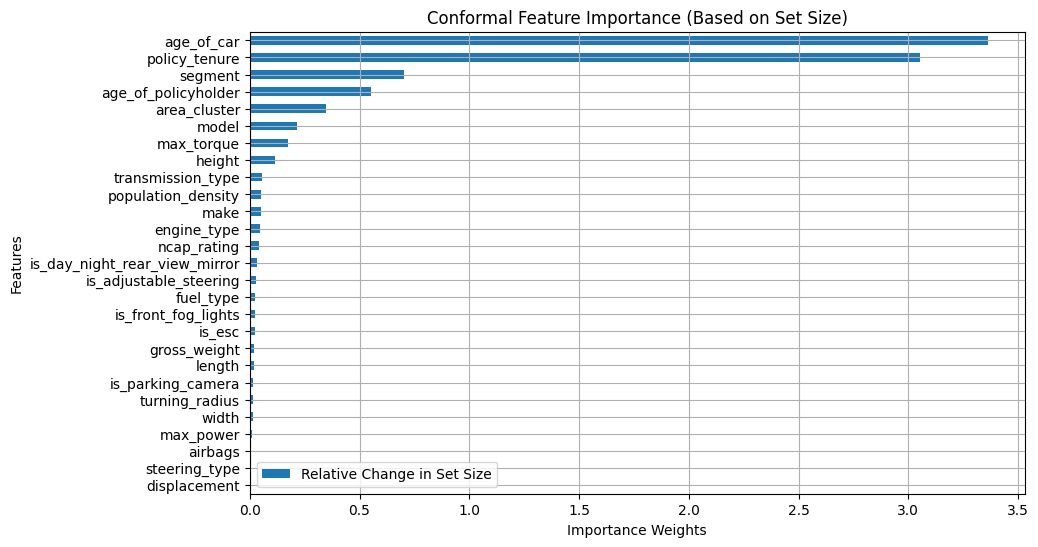

,Relative Change in Set Size
Perturbed_Column,
age_of_car,3.362755
policy_tenure,3.054393
segment,0.701596
age_of_policyholder,0.552601
area_cluster,0.347026
model,0.215005
max_torque,0.175399
height,0.116933
transmission_type,0.056580


In [17]:
type_of_metric = 'set_size'
noise_type = 'uniform'
alpha = 0.05
plot_conformal_explainer(model_base, X_Cal, y_cal, X_test, y_test, alpha, class_labels, type_of_metric, noise_type)

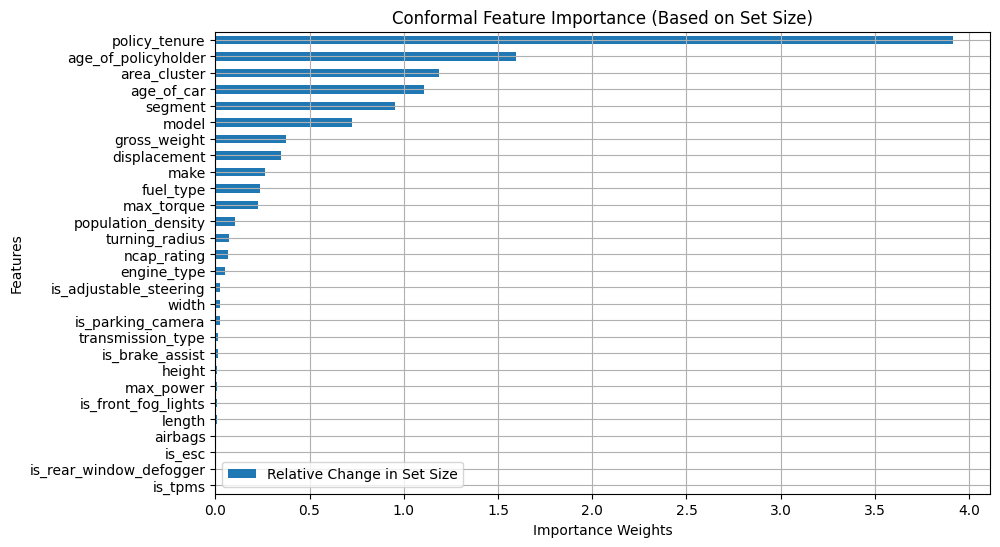

,Relative Change in Set Size
Perturbed_Column,
policy_tenure,3.916299
age_of_policyholder,1.596507
area_cluster,1.188186
age_of_car,1.107088
segment,0.952435
model,0.724228
gross_weight,0.375316
displacement,0.350798
make,0.263098


In [18]:
type_of_metric = 'set_size'
noise_type = 'gaussian'
alpha = 0.05
plot_conformal_explainer(model_base, X_Cal, y_cal, X_test, y_test, alpha, class_labels, type_of_metric, noise_type)

<Figure size 1000x1600 with 0 Axes>

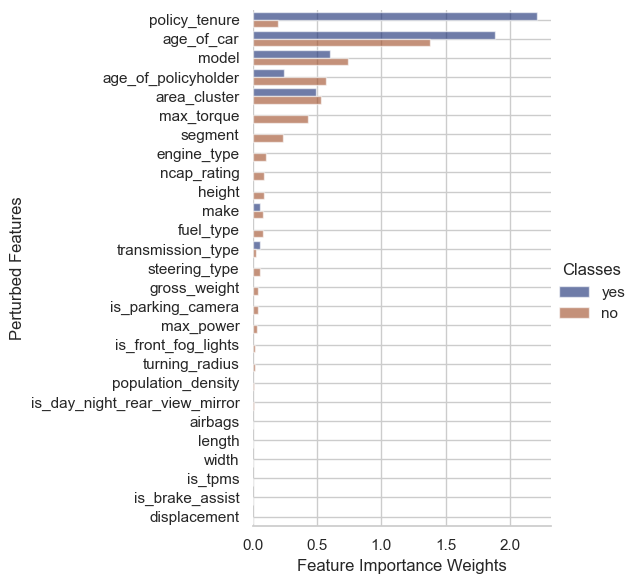

Group: no
                Feature Perturbed Class  Mean Relative Change
0                      age_of_car    no              1.379058
64                          model    no              0.742422
2             age_of_policyholder    no              0.573165
6                    area_cluster    no              0.530851
62                     max_torque    no              0.426989
74                        segment    no              0.238498
68                  policy_tenure    no              0.196184
12                    engine_type    no              0.103862
66                    ncap_rating    no              0.090399
20                         height    no              0.086552
58                           make    no              0.082705
14                      fuel_type    no              0.080782
76                  steering_type    no              0.053854
18                   gross_weight    no              0.042314
38              is_parking_camera    no              0.04231

In [19]:
type_of_metric = 'pred_set'
noise_type = 'uniform'
alpha = 0.05
plot_conformal_explainer(model_base, X_Cal, y_cal, X_test, y_test, alpha, class_labels, type_of_metric, noise_type)

<Figure size 1000x1600 with 0 Axes>

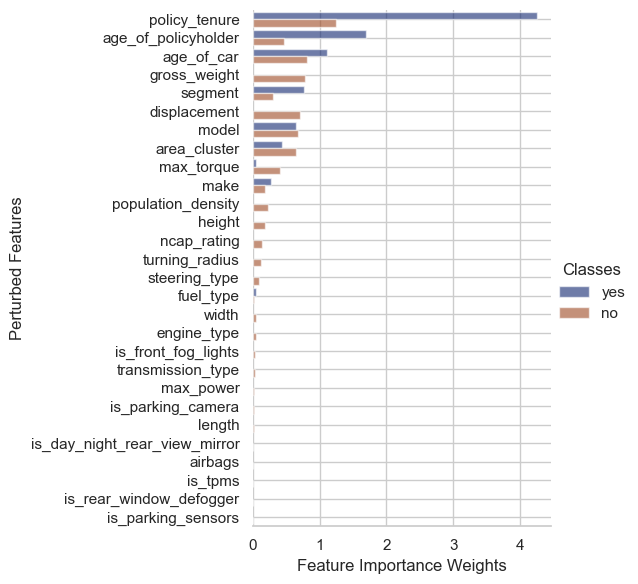

Group: no
                Feature Perturbed Class  Mean Relative Change
68                  policy_tenure    no              1.244422
0                      age_of_car    no              0.819357
18                   gross_weight    no              0.782813
10                   displacement    no              0.705878
64                          model    no              0.684721
6                    area_cluster    no              0.642407
2             age_of_policyholder    no              0.469303
62                     max_torque    no              0.411602
74                        segment    no              0.300046
70             population_density    no              0.234651
20                         height    no              0.192337
58                           make    no              0.180797
66                    ncap_rating    no              0.142330
80                 turning_radius    no              0.123096
76                  steering_type    no              0.08847

In [20]:
type_of_metric = 'pred_set'
noise_type = 'gaussian'
alpha = 0.05
plot_conformal_explainer(model_base, X_Cal, y_cal, X_test, y_test, alpha, class_labels, type_of_metric, noise_type)